In [19]:
import matplotlib.pyplot as plt
import fiona 
import pandas as pd 
import geopandas as gpd 
from datetime import date

In [20]:
kml_file_path = '../data/roads/A38.kml'

# set up fiona support
fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

gdf_lines = gpd.read_file(kml_file_path, driver='libkml')
gdf_lines.set_crs(epsg=4326, inplace=True)

gdf_lines.head()

,Name,Description,geometry
0,A38(M) motorway,,"LINESTRING Z (-1.86259 52.50981 0, -1.86454 52..."
1,A38 road,,"LINESTRING Z (-4.70138 50.47919 0, -4.703 50.4..."
2,A38 road,,"LINESTRING Z (-3.20375 50.98184 0, -3.20264 50..."
3,A38 road,,"LINESTRING Z (-3.11095 51.01323 0, -3.11058 51..."
4,A38 road,,"LINESTRING Z (-2.59844 51.45231 0, -2.59821 51..."


In [21]:
dominic_locations = '../data/people/marcus.csv'

df_dominic = pd.read_csv(dominic_locations)
df_dominic['postcode'] = df_dominic['postcode'].str.replace(' ', '')

df_dominic.head()

,postcode,from
0,EN14DT,30/09/1982
1,DE13AJ,01/01/1986
2,DE13EZ,01/01/1987
3,DE221AS,01/01/1994
4,M156BG,01/09/2002


In [22]:
import os
from tqdm import tqdm
import glob

folder_path = '../data/postcodes/codepo_gb'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Read and concatenate all CSV files into one DataFrame
df_list = [pd.read_csv(file, header=None) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

columns_to_drop = [1, 4, 5, 6, 7, 8, 9]

postcodes_df =  combined_df.drop(combined_df.columns[columns_to_drop], axis=1)

postcodes_df.columns = ['postcode', 'easting', 'northing']

postcodes_df['postcode'] = postcodes_df['postcode'].str.replace(' ', '')


In [23]:
df_merged = pd.merge(df_dominic, postcodes_df, on='postcode', how='left')

df_merged.head(10)

,postcode,from,easting,northing
0,EN14DT,30/09/1982,534824,199805
1,DE13AJ,01/01/1986,435079,336988
2,DE13EZ,01/01/1987,435017,337342
3,DE221AS,01/01/1994,434517,337602
4,M156BG,01/09/2002,384258,396979
5,DE221AS,01/05/2003,434517,337602
6,M146EW,01/09/2003,384824,393788
7,DE221AS,01/05/2004,434517,337602
8,M204SB,01/09/2004,385424,392689
9,DE221AS,01/05/2005,434517,337602


In [24]:
# Access the last row
last_row = df_merged.iloc[[-1]]

# Append the last row to the DataFrame
df_merged = pd.concat([df_merged, last_row], ignore_index=True)

df_merged.at[df_merged.index[-1], 'from']= date.today()

df_merged['from'] = pd.to_datetime(df_merged['from'])

df_merged.head(15)

df_merged['days'] = df_merged['from'].shift(-1) - df_merged['from']

df_merged = df_merged.drop(df_merged.index[-1])

df_merged.head(15)

C:\Users\DominicMcCaskill\AppData\Local\Temp\ipykernel_15292\3107830466.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_merged['from'] = pd.to_datetime(df_merged['from'])


,postcode,from,easting,northing,days
0,EN14DT,1982-09-30,534824,199805,1189 days
1,DE13AJ,1986-01-01,435079,336988,365 days
2,DE13EZ,1987-01-01,435017,337342,2557 days
3,DE221AS,1994-01-01,434517,337602,3165 days
4,M156BG,2002-09-01,384258,396979,242 days
5,DE221AS,2003-05-01,434517,337602,123 days
6,M146EW,2003-09-01,384824,393788,243 days
7,DE221AS,2004-05-01,434517,337602,123 days
8,M204SB,2004-09-01,385424,392689,242 days
9,DE221AS,2005-05-01,434517,337602,822 days


In [25]:
from pyproj import transform, Proj

v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy",
        towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")


def vectorized_convert(df):
    vlon36, vlat36 = vgrid(df['easting'].values, 
                           df['northing'].values, 
                           inverse=True)
    converted = transform(v36, v84, vlon36, vlat36)
    df['longitude'] = converted[0]
    df['latitude'] = converted[1]
    return df

c:\Users\DominicMcCaskill\repos\RoadLife\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
postcodes_df = vectorized_convert(postcodes_df)
postcodes_df.drop(columns=['easting', 'northing'], inplace=True)

postcodes_df.to_csv("../data/postcodes/postcodes.csv")

C:\Users\DominicMcCaskill\AppData\Local\Temp\ipykernel_15292\1656505409.py:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


In [60]:
df_lat = vectorized_convert(df_merged)

df_lat.head()

C:\Users\DominicMcCaskill\AppData\Local\Temp\ipykernel_10868\1656505409.py:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  converted = transform(v36, v84, vlon36, vlat36)


,postcode,from,easting,northing,days,longitude,latitude
0,EN14DT,1982-09-30,534824,199805,1189 days,-0.051290,51.680832
1,DE13AJ,1986-01-01,435079,336988,365 days,-1.479607,52.929159
2,DE13EZ,1987-01-01,435017,337342,2557 days,-1.480491,52.932345
3,DE221AS,1994-01-01,434517,337602,3165 days,-1.487902,52.934714
4,M156BG,2002-09-01,384258,396979,242 days,-2.238609,53.469309


In [61]:
columns_to_drop = ['from', 'easting', 'northing', 'postcode']
df_lat =  df_lat.drop(columns=columns_to_drop, axis=1)

df_lat.head()

,days,longitude,latitude
0,1189 days,-0.051290,51.680832
1,365 days,-1.479607,52.929159
2,2557 days,-1.480491,52.932345
3,3165 days,-1.487902,52.934714
4,242 days,-2.238609,53.469309


In [62]:
from shapely import Point

geometry = [Point(xy) for xy in zip(df_lat['longitude'], df_lat['latitude'])]

gdf_points = gpd.GeoDataFrame(df_lat, geometry=geometry)

gdf_points.set_crs(epsg=4326, inplace=True)

print(gdf_points)
print(gdf_points.crs)
print(gdf_lines.crs)

#gdf_points = gdf_points.to_crs(epsg=3857)
#gdf_lines = gdf_lines.to_crs(epsg=3857)

gdf_points.sindex  # Create spatial index for points
gdf_lines.sindex  #

gdf_lines.head()

        days  longitude   latitude                   geometry
0  1189 days  -0.051290  51.680832  POINT (-0.05129 51.68083)
1   365 days  -1.479607  52.929159  POINT (-1.47961 52.92916)
2  2557 days  -1.480491  52.932345  POINT (-1.48049 52.93234)
3  3165 days  -1.487902  52.934714   POINT (-1.4879 52.93471)
4   242 days  -2.238609  53.469309  POINT (-2.23861 53.46931)
5   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)
6   243 days  -2.229928  53.440644  POINT (-2.22993 53.44064)
7   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)
8   242 days  -2.220844  53.430782  POINT (-2.22084 53.43078)
9   822 days  -1.487902  52.934714   POINT (-1.4879 52.93471)
10  274 days  -1.491144  52.931069  POINT (-1.49114 52.93107)
11 2102 days  -1.493944  52.920546  POINT (-1.49394 52.92055)
12 1734 days  -1.485311  52.933615  POINT (-1.48531 52.93362)
13 2083 days  -1.499222  52.947833  POINT (-1.49922 52.94783)
EPSG:4326
EPSG:4326


,Name,Description,geometry
0,A38(M) motorway,,"LINESTRING Z (-1.86259 52.50981 0, -1.86454 52..."
1,A38 road,,"LINESTRING Z (-4.70138 50.47919 0, -4.703 50.4..."
2,A38 road,,"LINESTRING Z (-3.20375 50.98184 0, -3.20264 50..."
3,A38 road,,"LINESTRING Z (-3.11095 51.01323 0, -3.11058 51..."
4,A38 road,,"LINESTRING Z (-2.59844 51.45231 0, -2.59821 51..."


In [63]:
from geopy.distance import geodesic

# Function to compute geodesic distance from a point to all lines
def min_geodesic_distance_to_lines(point, lines_gdf):
    point_coords = (point.y, point.x)  # (latitude, longitude)
    min_dist = float('inf')
    for line in lines_gdf.geometry:
        for segment in list(line.coords):
            segment_coords = (segment[1], segment[0])  # (latitude, longitude)
            dist = geodesic(point_coords, segment_coords).meters
            if dist < min_dist:
                min_dist = dist
    return min_dist

# Apply the function to each point in the points GeoDataFrame
gdf_points['min_geodesic_distance'] = gdf_points['geometry'].apply(min_geodesic_distance_to_lines, lines_gdf=gdf_lines)

# View the updated GeoDataFrame with distances
print(gdf_points)

        days  longitude   latitude                   geometry  \
0  1189 days  -0.051290  51.680832  POINT (-0.05129 51.68083)   
1   365 days  -1.479607  52.929159  POINT (-1.47961 52.92916)   
2  2557 days  -1.480491  52.932345  POINT (-1.48049 52.93234)   
3  3165 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
4   242 days  -2.238609  53.469309  POINT (-2.23861 53.46931)   
5   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
6   243 days  -2.229928  53.440644  POINT (-2.22993 53.44064)   
7   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
8   242 days  -2.220844  53.430782  POINT (-2.22084 53.43078)   
9   822 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
10  274 days  -1.491144  52.931069  POINT (-1.49114 52.93107)   
11 2102 days  -1.493944  52.920546  POINT (-1.49394 52.92055)   
12 1734 days  -1.485311  52.933615  POINT (-1.48531 52.93362)   
13 2083 days  -1.499222  52.947833  POINT (-1.49922 52.94783)   

    min_geodesic_distanc

In [64]:
# Function to compute minimum distance from a point to multiple lines
def min_distance_to_lines(point, gdf_lines):
    return gdf_lines.distance(point).min()

gdf_points['min_distance'] = gdf_points['geometry'].apply(min_distance_to_lines, gdf_lines=gdf_lines)

gdf_points.head(15)

C:\Users\DominicMcCaskill\AppData\Local\Temp\ipykernel_10868\3314492234.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return gdf_lines.distance(point).min()


,days,longitude,latitude,geometry,min_geodesic_distance,min_distance
0,1189 days,-0.051290,51.680832,POINT (-0.05129 51.68083),148122.508252,1.860591
1,365 days,-1.479607,52.929159,POINT (-1.47961 52.92916),1334.557235,0.016157
2,2557 days,-1.480491,52.932345,POINT (-1.48049 52.93234),1115.114934,0.013028
3,3165 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003
4,242 days,-2.238609,53.469309,POINT (-2.23861 53.46931),70020.373321,0.876575
5,123 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003
6,243 days,-2.229928,53.440644,POINT (-2.22993 53.44064),67667.051252,0.849444
7,123 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003
8,242 days,-2.220844,53.430782,POINT (-2.22084 53.43078),66541.211551,0.836037
9,822 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003


In [65]:
from geopy.distance import geodesic

# Function to compute geodesic distance from a point to all lines
def min_geodesic_distance_to_lines(point, lines_gdf):
    point_coords = (point.y, point.x)  # (latitude, longitude)
    min_dist = float('inf')
    for line in lines_gdf.geometry:
        for segment in list(line.coords):
            segment_coords = (segment[1], segment[0])  # (latitude, longitude)
            dist = geodesic(point_coords, segment_coords).meters
            if dist < min_dist:
                min_dist = dist
    return min_dist

# Apply the function to each point in the points GeoDataFrame
gdf_points['min_geodesic_distance'] = gdf_points['geometry'].apply(min_geodesic_distance_to_lines, lines_gdf=gdf_lines)

# View the updated GeoDataFrame with distances
print(gdf_points)

        days  longitude   latitude                   geometry  \
0  1189 days  -0.051290  51.680832  POINT (-0.05129 51.68083)   
1   365 days  -1.479607  52.929159  POINT (-1.47961 52.92916)   
2  2557 days  -1.480491  52.932345  POINT (-1.48049 52.93234)   
3  3165 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
4   242 days  -2.238609  53.469309  POINT (-2.23861 53.46931)   
5   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
6   243 days  -2.229928  53.440644  POINT (-2.22993 53.44064)   
7   123 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
8   242 days  -2.220844  53.430782  POINT (-2.22084 53.43078)   
9   822 days  -1.487902  52.934714   POINT (-1.4879 52.93471)   
10  274 days  -1.491144  52.931069  POINT (-1.49114 52.93107)   
11 2102 days  -1.493944  52.920546  POINT (-1.49394 52.92055)   
12 1734 days  -1.485311  52.933615  POINT (-1.48531 52.93362)   
13 2083 days  -1.499222  52.947833  POINT (-1.49922 52.94783)   

    min_geodesic_distanc

In [66]:
gdf_points['total_day_distance'] = gdf_points['min_geodesic_distance']*gdf_points['days'].dt.days

gdf_points.head(15)

,days,longitude,latitude,geometry,min_geodesic_distance,min_distance,total_day_distance
0,1189 days,-0.051290,51.680832,POINT (-0.05129 51.68083),148122.508252,1.860591,1.761177e+08
1,365 days,-1.479607,52.929159,POINT (-1.47961 52.92916),1334.557235,0.016157,4.871134e+05
2,2557 days,-1.480491,52.932345,POINT (-1.48049 52.93234),1115.114934,0.013028,2.851349e+06
3,3165 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003,1.745052e+06
4,242 days,-2.238609,53.469309,POINT (-2.23861 53.46931),70020.373321,0.876575,1.694493e+07
5,123 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003,6.781718e+04
6,243 days,-2.229928,53.440644,POINT (-2.22993 53.44064),67667.051252,0.849444,1.644309e+07
7,123 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003,6.781718e+04
8,242 days,-2.220844,53.430782,POINT (-2.22084 53.43078),66541.211551,0.836037,1.610297e+07
9,822 days,-1.487902,52.934714,POINT (-1.4879 52.93471),551.359210,0.007003,4.532173e+05


In [67]:
print(gdf_points['total_day_distance'].sum()/gdf_points['days'].dt.days.sum())

15532.310533774138


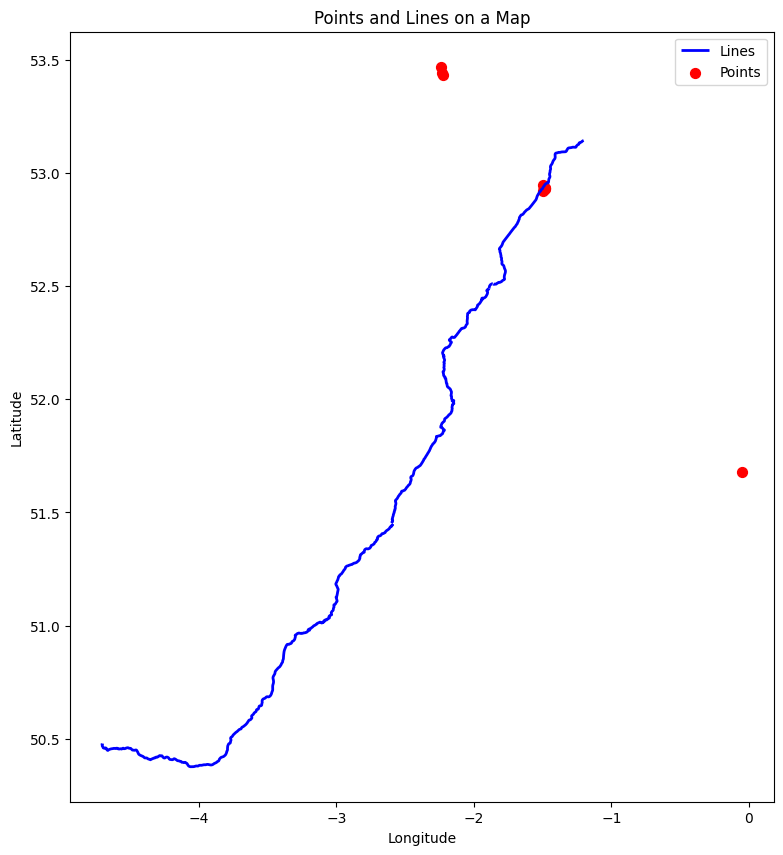

In [68]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the lines
gdf_lines.plot(ax=ax, color='blue', linewidth=2, label='Lines')

# Plot the points
gdf_points.plot(ax=ax, color='red', marker='o', markersize=50, label='Points')

# Add a legend
plt.legend()

# Set title and labels
plt.title('Points and Lines on a Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [69]:
import folium
from shapely.geometry import Point, LineString


gdf_lines = gdf_lines.to_crs(epsg=4326)
# Create a folium map centered on the average latitude and longitude
m = folium.Map(location=[gdf_points['latitude'].mean(), gdf_points['longitude'].mean()], zoom_start=2)

# Add points to the map
for idx, row in gdf_points.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"Point: {idx}").add_to(m)

# Add lines to the map
for idx, row in gdf_lines.iterrows():
    folium.PolyLine(locations=[(coord[1], coord[0]) for coord in row['geometry'].coords], color='blue').add_to(m)
    folium.PolyLine(locations=[(coord[1], coord[0]) for coord in row['geometry'].coords], color='blue').add_to(m)

# Save the map to an HTML file and display
m.save('map.html')
m